In the mid-2010s, basketball underwent a revolutionary shift, largely driven by the rise of analytics. This new approach emphasised efficiency in scoring, leading to a dramatic increase in three-point shooting across the NBA. Two teams at the forefront of this transformation were the Houston Rockets, under the guidance of General Manager Daryl Morey, and the Golden State Warriors, led by head coach Steve Kerr. Morey’s data-driven philosophy prioritised the three-pointer as a key to success, challenging traditional basketball strategies. Meanwhile, the Warriors, with sharpshooters like Stephen Curry, showcased the power of a three-point-heavy offense by dominating the league and securing multiple championships. This analytics revolution not only redefined how the game is played but also set a new standard for what it takes to win in the modern NBA. 

In this notebook, I aim to answer the question: **Do NBA teams that attempt a higher percentage of three-point shots have a higher win rate compared to teams that focus more on two-point shots?** I will be using the 2023-24 NBA Regular Season as my data.

1. Scrape Box Score stats which include win/loss, 3 pointers made, 3 pointers attempted, field goals made and field goals attempted from the nba_api package
2. Clean data and set up target variable: 3 point attempt (3PA) rate
3. EDA: summary statistics, visualise distrbution between 3PA and win rates, check for multicollinearity with a correlation matrix
4. Build a logistic regression model to determine the effect of 3PA rate on wins
5. Interpret results and determine whether the effect is statistically significant

### Scrape data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nba_api.stats.endpoints import leaguegamelog
pd.set_option('display.max_columns', None)

The leaguegamelog endpoint gives us all the necessary stats of all the games in an NBA season. Since we are only taking the results of the 2023-24 regular season, we set the corresponding paramters as such.

In [2]:
season = '2023-24'
gamelog = leaguegamelog.LeagueGameLog(season=season, season_type_all_star='Regular Season')

In [3]:
df = gamelog.get_data_frames()[0]
df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,1610612747,LAL,Los Angeles Lakers,0022300061,2023-10-24,LAL @ DEN,L,240,41,90,0.456,10,29,0.345,15,20,0.750,13,31,44,23,5,4,12,18,107,-12,1
1,22023,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,240,48,91,0.527,14,34,0.412,9,12,0.750,9,33,42,29,9,6,12,15,119,12,1
2,22023,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24,PHX @ GSW,W,240,42,95,0.442,11,33,0.333,13,17,0.765,17,43,60,23,5,7,19,22,108,4,1
3,22023,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24,GSW vs. PHX,L,240,36,101,0.356,10,43,0.233,22,28,0.786,18,31,49,19,11,6,11,23,104,-4,1
4,22023,1610612753,ORL,Orlando Magic,0022300066,2023-10-25,ORL vs. HOU,W,240,42,87,0.483,9,34,0.265,23,26,0.885,17,40,57,19,8,6,16,20,116,30,1


In [4]:
df.shape

(2460, 29)

So we can see that given 30 teams each play 82 games, we have 2,460 rows. However, in total there are 1,230 games played, since two rows belong to the two opponents of the same game.

### Clean data

Since we have too many columns, we remove the ones that are irrelevant to our analysis. The columns that we are keeping are:
- TEAM_ABBREVIATION: better indicator than TEAM_ID
- GAME_ID
- GAME_DATE: for chronological analysis
- MATCHUP: to extract opponent strength and Home/Away to control
- WL: the dependent variable
- FGM: useful for comparing overall shooting vs 3pt shooting
- FGA
- FG_PCT
- FG3M: core to analysis
- FG3A
- FG3_PCT
- REB: important stat to control for
- AST
- PTS: context of wins and losses
- PLUS_MINUS: extra context on impact

In [5]:
df = df[['TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'FGM', 'FGA', 'FG_PCT',
        'FG3M', 'FG3A', 'FG3_PCT', 'REB', 'AST', 'PTS', 'PLUS_MINUS']]

Checking for missing values:

In [6]:
df.isnull().sum()

TEAM_ABBREVIATION    0
GAME_ID              0
GAME_DATE            0
MATCHUP              0
WL                   0
FGM                  0
FGA                  0
FG_PCT               0
FG3M                 0
FG3A                 0
FG3_PCT              0
REB                  0
AST                  0
PTS                  0
PLUS_MINUS           0
dtype: int64

Verifying data types:

In [7]:
df.dtypes

TEAM_ABBREVIATION     object
GAME_ID               object
GAME_DATE             object
MATCHUP               object
WL                    object
FGM                    int64
FGA                    int64
FG_PCT               float64
FG3M                   int64
FG3A                   int64
FG3_PCT              float64
REB                    int64
AST                    int64
PTS                    int64
PLUS_MINUS             int64
dtype: object

We can turn our dependent variable WL into a binary value, either 1 or 0. To do that, we map all the W to 1 and L to 0.

In [8]:
df['WL'] = df['WL'].map({'W': 1, 'L': 0})

In [9]:
df['WL']

0       0
1       1
2       1
3       0
4       1
       ..
2455    1
2456    0
2457    0
2458    1
2459    0
Name: WL, Length: 2460, dtype: int64

We also convert the game date column to datetime:

In [10]:
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

Doing a sense check on the percentage columns, just to see all the values are between 0 and 1:

In [11]:
print(df['FG3_PCT'].between(0, 1).all())
print(df['FG_PCT'].between(0, 1).all())

True
True


We also want to split the matchup column to just the team abbreviation, while isolating whether it's a home or away game.

We know that the second team is always the opponent, so we can extract them to a different column 'OPPONENT'. We also know that based on the presence of '@' or 'vs.', we can tell if it's a home or away game.

In [12]:
df['OPPONENT'] = df['MATCHUP'].apply(lambda x: x.split(' ')[-1])
df['IS_HOME'] = df['MATCHUP'].apply(lambda x: 1 if '@' in x else 0)

We also want a column for the three-point attempt rate, calculated by dividing the FG3A by the FGA.

In [13]:
df['3PT_ATTEMPT_RATE'] = df['FG3A']/df['FGA'].astype(float)

Finally, we can extract the number of 2 pointers attempted by subtracting the FG3M from the FGM, and similar for correpsonding columns.

In [14]:
df['FG2M'] = df['FGM'] - df['FG3M']
df['FG2A'] = df['FGA'] - df['FG3A']
df['FG2_PCT'] = df['FG2M']/df['FG2A'].astype(float)

In [15]:
df.head()

,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,REB,AST,PTS,PLUS_MINUS,OPPONENT,IS_HOME,3PT_ATTEMPT_RATE,FG2M,FG2A,FG2_PCT
0,LAL,0022300061,2023-10-24,LAL @ DEN,0,41,90,0.456,10,29,0.345,44,23,107,-12,DEN,1,0.322222,31,61,0.508197
1,DEN,0022300061,2023-10-24,DEN vs. LAL,1,48,91,0.527,14,34,0.412,42,29,119,12,LAL,0,0.373626,34,57,0.596491
2,PHX,0022300062,2023-10-24,PHX @ GSW,1,42,95,0.442,11,33,0.333,60,23,108,4,GSW,1,0.347368,31,62,0.500000
3,GSW,0022300062,2023-10-24,GSW vs. PHX,0,36,101,0.356,10,43,0.233,49,19,104,-4,PHX,0,0.425743,26,58,0.448276
4,ORL,0022300066,2023-10-25,ORL vs. HOU,1,42,87,0.483,9,34,0.265,57,19,116,30,HOU,0,0.390805,33,53,0.622642


### Exploratory data analysis (EDA)

We start our EDA by checking the summary statistics:

In [16]:
df.describe()

,WL,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,REB,AST,PTS,PLUS_MINUS,IS_HOME,3PT_ATTEMPT_RATE,FG2M,FG2A,FG2_PCT
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,0.500000,42.170325,88.903252,0.475212,12.836992,35.103659,0.364944,43.541463,26.670732,114.211382,0.000000,0.500000,0.395181,29.333333,53.799593,0.546560
std,0.500102,5.343417,7.013117,0.054980,3.837044,6.541778,0.083411,6.575082,5.101065,12.845883,15.785622,0.500102,0.068359,5.332715,7.639131,0.073535
min,0.000000,26.000000,67.000000,0.277000,2.000000,12.000000,0.069000,25.000000,11.000000,73.000000,-62.000000,0.000000,0.142857,11.000000,30.000000,0.321429
25%,0.000000,38.000000,84.000000,0.438000,10.000000,30.000000,0.310000,39.000000,23.000000,105.000000,-10.000000,0.000000,0.347826,26.000000,49.000000,0.500000
50%,0.500000,42.000000,89.000000,0.475000,13.000000,35.000000,0.365500,43.000000,27.000000,114.000000,0.000000,0.500000,0.393617,29.000000,54.000000,0.545455
75%,1.000000,46.000000,93.000000,0.512000,15.000000,39.000000,0.417000,48.000000,30.000000,123.000000,10.000000,1.000000,0.442105,33.000000,59.000000,0.596154
max,1.000000,65.000000,119.000000,0.671000,27.000000,63.000000,0.645000,74.000000,50.000000,157.000000,62.000000,1.000000,0.638554,50.000000,83.000000,0.767442


Some notable observations:
- The median 3-point percentage made is 36.6%. Comparatively, the median 2-point percentage made is 54.5%. If we compare the number of points per possession for a 2-point attempt versus a 3-point attempt, we get 0.545 x 2 = 1.09 and 40.366 x 3 = 1.10. 

It is slightly higher for a 3-point attempt on median.
- The median 3-point attempt percentage is 39.4%. 
- The median standard deviation for 2-point percentage made is 7.4%, while the median standard deviation for 3-point percentage made is 8.3%. This illustrates that there is more variability in shooting threes, which makes sense since they are harder to score and therefore less reliable.

Now let's do a correlation matrix.

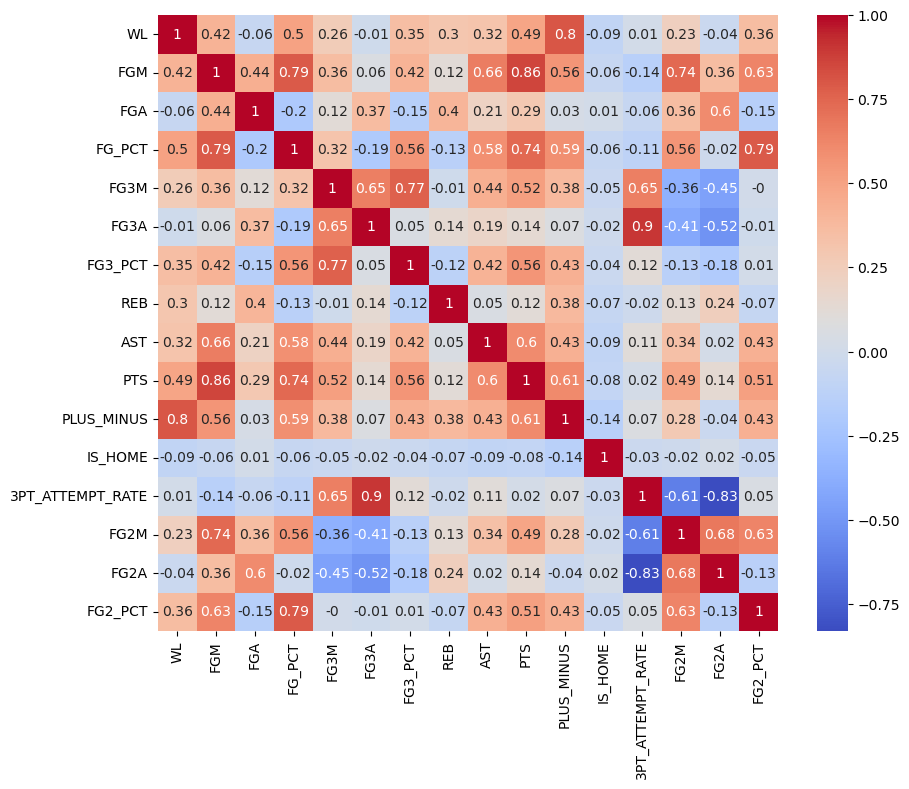

In [17]:
corr_matrix = df.corr(numeric_only=True).round(2)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Some key observations:
- The 3-point percentage made has a slight correlation to win rate at 0.35, which is also similar, albeit slightly under the correlation between 2-point percentage made and win rate at 0.36. The overall field goal percentage has a stronger correlation to win rate at 0.5, telling us that it's not what kind of shots are being scored, as long as they are being scored at a high clip.
- The 3-point attempt rate has negligible correlation to winning, suggesting that simply attempting more threes doesn't directly influence the outcome.
- The 3-point attempt rate has a small correlation to 3-point percentage, at 0.12, telling us a higher 3-point attempt rate does not strongly predict 3-point shooting accuracy.
- In fact, the 3-point attempt rate has no strong positive or negative correlation to any stat, except positively to 3 pointers made and attempted as expected, as well as negatively to 2 pointers made and attempted (more 3s attempted means less 2s attempted and made).

Let's also visualise the distribution of 3-point attempt rate against wins with a box plot.

<Axes: xlabel='WL', ylabel='3PT_ATTEMPT_RATE'>

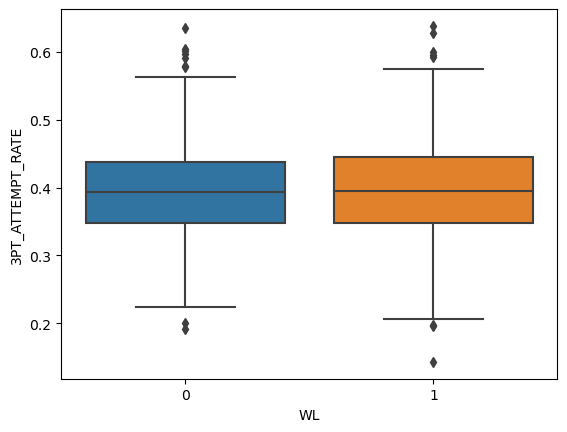

In [18]:
sns.boxplot(x='WL', y='3PT_ATTEMPT_RATE', data=df)

From this, like shown from the heat map, we really don't see much of a difference for the distribution of 3-point attempt rate between wins and losses. The median is nearly the same; the 25th percentile is also nearly the same, and the 75th percentile is slightly higher for wins versus losses. There are also more extreme outliers both on the high and low sides of the spectrum for wins, however overall the differences are negligible.

### Logistic regression

The initial EDA doesn't show promising results for the problem statement, however it doesn't control for other variables. We will perform a logistic regression.

Since the 3PT attempt rate is directly derived from FG3A and FGA, we will remove these from the features to avoid multicollinearity. We also must remove plus-minus, since whether the number is positive or negative correlates nearly perfectly with whether they won or not. Let's define the features X and the target y.

In [19]:
X = df[['3PT_ATTEMPT_RATE', 'FG3M', 'FG3_PCT', 'FGM', 'FG_PCT', 'FG2M', 'FG2A', 'FG2_PCT',
       'REB', 'AST', 'PTS', 'IS_HOME']]
y = df['WL']

We still need to continue removing highly correlated variables by using Variance Inflation Factor (VIF). If the VIF is greater than 10, this tells us there is significant multicollinearity that needs to be corrected.

In [20]:
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

/Users/tony/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,1.836922e+04
1,3PT_ATTEMPT_RATE,1.111326e+02
2,FG3M,inf
3,FG3_PCT,3.171266e+01
4,FGM,inf
5,FG_PCT,1.368153e+02
6,FG2M,inf
7,FG2A,1.447474e+02
8,FG2_PCT,6.420622e+01
9,REB,1.227554e+00


We definitely need to remove all the infinite VIF values, since this suggests perfect multicollinearity. Let's retry after.

In [21]:
X = df[['3PT_ATTEMPT_RATE', 'FG3_PCT', 'FG_PCT', 'FG2A', 'FG2_PCT',
       'REB', 'AST', 'PTS', 'IS_HOME']]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,const,1371.373379
1,3PT_ATTEMPT_RATE,10.744788
2,FG3_PCT,19.239450
3,FG_PCT,59.167968
4,FG2A,8.105197
5,FG2_PCT,34.972248
6,REB,1.225425
7,AST,1.965087
8,PTS,5.147515
9,IS_HOME,1.019740


Out of these, FG3_PCT, FG_PCT and FG2_PCT show values greater than 10. Perhaps by removing only one of them, we can get all the variables to show less than 10. We keep only the FG3_PCT and FG2_PCT, since there is less correlation between those two than FG3_PCT and FG_PCT (naturally because FG_PCT comprises FG3M). As a result, we also get rid of FG2A as that is a part of FG2_PCT.

In [22]:
X = df[['3PT_ATTEMPT_RATE', 'FG3_PCT', 'FG2_PCT',
       'REB', 'AST', 'PTS', 'IS_HOME']]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,const,172.749409
1,3PT_ATTEMPT_RATE,1.038465
2,FG3_PCT,2.072269
3,FG2_PCT,1.882117
4,REB,1.175973
5,AST,1.725538
6,PTS,2.859902
7,IS_HOME,1.013892


Standardising the features to ensure that all calculations are based on the number of standard deviations:

In [23]:
X = df[['3PT_ATTEMPT_RATE', 'FG3_PCT', 'FG2_PCT',
       'REB', 'AST', 'PTS', 'IS_HOME']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Adding an intercept term:

In [24]:
X_scaled = sm.add_constant(X_scaled)
X_scaled

,const,3PT_ATTEMPT_RATE,FG3_PCT,FG2_PCT,REB,AST,PTS,IS_HOME
0,1.0,-1.067500,-0.239158,-0.521805,0.069753,-0.719747,-0.561491,1.0
1,1.0,-0.315376,0.564260,0.679152,-0.234488,0.456717,0.372850,-1.0
2,1.0,-0.699571,-0.383054,-0.633294,2.503677,-0.719747,-0.483629,1.0
3,1.0,0.447167,-1.582186,-1.336831,0.830354,-1.504057,-0.795076,-1.0
4,1.0,-0.064031,-1.198464,1.034840,2.047316,-1.504057,0.139265,-1.0
...,...,...,...,...,...,...,...,...
2455,1.0,0.924021,-0.562924,-0.371723,2.047316,0.652794,-0.561491,-1.0
2456,1.0,0.211539,-1.198464,-1.049673,-0.234488,-1.504057,-2.196588,1.0
2457,1.0,-0.590269,1.439625,-1.086684,-0.082368,0.652794,-0.327906,-1.0
2458,1.0,0.649344,1.319712,-0.233244,0.526114,1.829258,0.450712,1.0


Fitting regression model and viewing the summary:

In [25]:
model = sm.Logit(y, X_scaled)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.436488
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     WL   No. Observations:                 2460
Model:                          Logit   Df Residuals:                     2452
Method:                           MLE   Df Model:                            7
Date:                Thu, 12 Sep 2024   Pseudo R-squ.:                  0.3703
Time:                        00:41:50   Log-Likelihood:                -1073.8
converged:                       True   LL-Null:                       -1705.1
Covariance Type:            nonrobust   LLR p-value:                1.886e-268
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0068      0.054     -0.127      0.899      -0.112       0.098
3PT_ATTEMPT_RATE    -0.1488      0.054     -2.740      0.006      -0.255      -0.042
FG3_PCT              1.3485      0.090     15.021      0.000       1.173       1.524
FG2_PCT              1.3122      0.086     15.269      0.000       1.144       1.481
REB                  1.2959      0.072     17.924      0.000       1.154       1.438
AST                 -0.2086      0.071     -2.953      0.003      -0.347      -0.070
PTS                  0.2753      0.092      2.996      0.003       0.095       0.455
IS_HOME             -0.1158      0.054     -2.158      0.031      -0.221      -0.011
====================================================================================
"""

From this analysis, we can see that 3-point attempt rate is actually negatively correlated to Win Loss (given that the coefficient is negative), and so it means that an increase in 3-point attempt rate is associated with a slightly lower likelihood of winning, which is surprising considering it completely counters the original problem we sought to answer. 

To interpret the magnitude of this result, i.e. calculate the effect of a 1% increase in 3-point attempt rate on the odds of winning, we need to find the **odds ratio**. But first, we have scaled data, which means the data is based on standard deviations, not percentages. To convert it back, we must calculate what a 1% increase means in scaled units.

The standard deviation of 3-point attempt rate, as shown previously in the summary statistics, is 0.068359. The original scale is also from 0 to 1, so 1% counts as 0.01. So, to calculate the scaled change, we divide to get the scaled change: 

$$\frac{0.01}{0.068359} = 0.1463$$

Now we multiply the logistic regression coefficient in the results to get the log-odds:

$$-0.1488 \times 0.1463 \approx -0.02177$$ 

Finally, to convert log-odds to odds ratio:

$$\exp(-0.02177) \approx 0.9785$$ 

This means that for a 1% increase in the 3-point attempt rate, the odds of winning decrease by 

$$(1-0.9785) = 0.0215 = 2.15\%$$

The effect is statistically significant at the 95% level, as indicated by the p-value being less than 0.05 (0.006). 

By contrast, looking at the results of 3-point percentage, we get an odds ratio of 1.1756, meaning that for each 1% increase in 3-point percentage, the odds of winning increase by 17.56%. This shows a substantial positive effect improving 3-point shooting accuracy has on the likelihood of winning.

Hence, with these results, the hypothesis that we originally sought to answer has not only been proven false, it has also gone the opposite away, albeit slightly. We can conclude from our findings that **NBA teams that attempt a higher percentage of three-point shots do NOT have a higher win rate than NBA teams that focus more on two-point shots**. Rather, it is much more important that the threes that NBA teams do shoot count, prioritising accuracy over volume.